
### Divvy has made its Data Open sourced [here](https://divvy-tripdata.s3.amazonaws.com/index.html)

Prophet is particularly good at modeling time series that have multiple seasonalities and doesn’t face some of the drawbacks of other algorithms. At its core Prophet is the **sum of three functions of time plus an error term**:

### The 3 functions of time are - growthg(t), seasonality s(t), holidays h(t) , and then there is the error e_t :**

### The growth function has three main options:

**growth='linear':** This parameter specifies the type of trend component in the model. A linear trend assumes that the underlying growth rate is constant over time. This is the default setting for Prophet. It uses a set of piecewise linear equations with differing slopes between change points.

When linear growth is used, the growth term will look similar to the classic `y = mx + b` except the slope(m) and offset(b) are variable and will change value at each changepoint.

Change points are points in time where a time series experiences a shift in its underlying patterns or trends. For example, a change point may occur when a stock price suddenly jumps in response to a major news event, or when a seasonal pattern shifts due to changes in weather or consumer behavior.

**Logistic Growth:** This setting is useful when your time series has a cap or a floor in which the values you are modeling becomes saturated and can’t surpass a maximum or minimum value (think carrying capacity).
When logistic growth is used, the growth term will look similar to a typical equation for a logistic curve, except it the carrying capacity (C) will vary as a function of time and the growth rate (k) and the offset(m) are variable and will change value at each change point.

**Flat:** Lastly, you can choose a flat trend when there is no growth over time (but there still may be seasonality). If set to flat the growth function will be a constant value.

## Additive

In this case the components are added. This is roughly represented as:

```
y(t) = Trend(t) + Seasonality(t) + Residual(t)

```

## Multiplicative

In this case components are multiplied. This is roughly represented as:

```
y(t) = Trend(t) * Seasonality(t) * Residual(t)
```

--------------------

## Basic Theory on how `seasonality_mode` affect  how holidays are incorporated into the forecast

## In a time series model, the base trend represents the overall pattern of the data without considering the seasonal and holiday effects.

When you create a Prophet model, you have the option to configure the seasonality mode. There are two options for seasonality_mode: "additive" and "multiplicative". This mode affects how the seasonality components are combined in the model and also how holidays are incorporated into the forecast.

### Additive seasonality:
In additive mode, the seasonal and holiday components are added to the base trend to create the final forecast. This mode assumes that the effect of the seasonal components and holidays remains constant over time, regardless of the magnitude of the base trend. Additive seasonality is generally suitable for time series data with a constant or linear trend.

### Multiplicative seasonality:

In multiplicative mode, the seasonal and holiday components are multiplied by the base trend to create the final forecast. This mode assumes that the effect of the seasonal components and holidays increases or decreases proportionally with the magnitude of the base trend. Multiplicative seasonality is more suitable for time series data with an exponential or non-linear trend.

### When the seasonality_mode is set to "multiplicative", the impact of holidays on the forecast will also be treated as a multiplicative factor. This means that the holiday effect will be proportionally stronger when the base trend is higher and weaker when the base trend is lower. Conversely, when the seasonality_mode is set to "additive", the holiday effect will be constant and independent of the base trend.

In summary, the seasonality_mode setting in a Prophet time series project affects not only the seasonal components but also how holidays are incorporated into the forecast. The choice between additive and multiplicative seasonality depends on the characteristics of your time series data and how the seasonality and holiday effects interact with the base trend.

-----------------

## More Explanation on Multiplicative seasonality:

When using the multiplicative mode in Prophet, the seasonal and holiday components are multiplied by the base trend to create the final forecast. This implies that the impact of seasonal and holiday components on the forecast is proportional to the base trend.

In other words, when the base trend is high, the multiplicative seasonal and holiday components will cause a larger absolute change in the forecast compared to when the base trend is low. The multiplicative effects are expressed as a percentage deviation from the base trend because their impact scales with the magnitude of the trend.

For example, suppose the base trend is 1000, and the multiplicative seasonal effect is 10%. In this case, the final forecast would be 1000 * 1.1 = 1100, which is a 10% increase from the base trend. If the base trend were 2000, the same 10% multiplicative seasonal effect would result in a final forecast of 2000 * 1.1 = 2200, which is a 20% increase from the original trend.

The multiplicative mode is suitable for time series data with an exponential or non-linear trend, where the magnitude of seasonal and holiday effects is expected to vary depending on the level of the base trend. By setting seasonality_mode='multiplicative', you are acknowledging that the seasonal and holiday effects in your time series data will have a proportionally larger or smaller impact depending on the underlying trend.

In [1]:
# !pip install prophet openpyxl

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot


## Adding default country holidays

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

In [4]:
ROOT_DIR = '../input/'

In [5]:

df = pd.read_csv(ROOT_DIR + 'divvy_daily.csv')

df.head(2)

,date,rides,temperature,weather
0,1/1/2014,95,19.483158,rain or snow
1,1/2/2014,111,16.833333,rain or snow


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         1458 non-null   object 
 1   rides        1458 non-null   int64  
 2   temperature  1458 non-null   float64
 3   weather      1458 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 45.7+ KB


Input to Prophet is a dataframe with minimum two columns : ds and y.

ds is datestamp column and should be as per pandas datatime format, YYYY-MM-DD or YYYY-MM-DD HH:MM:SS for a timestamp.

y is the numeric column we want to predict or forecast.

In [7]:

df = df[['date', 'rides']]
df['date'] = pd.to_datetime(df['date'])
df.columns = ['ds', 'y']



Prophet follows sklearn model API of creating an instance of the Prophet, fitting the data on Prophet object and then predict the future values.

---------------

This dataset should be modeled with multiplicative seasonality and also the yearly seasonality should be constrained a bit by setting the Fourier order to 4.

Now, to complete the model, all we need to do is 
 - call fit on the training DataFrame, 
 - make our future DataFrame, and 
 - call predict on it. 
 
We will plot the forecast and components to view our results:

In [8]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=4)

# Adding default country holidays

Prophet uses the Python holidays package to populate a default list of holidays by country and,
optionally, by state or province. To specify which region to build a holiday list for, Prophet requires
the name or ISO code of that country.

In [9]:
model.add_country_holidays(country_name='US')

In [10]:
model.fit(df)
future = model.make_future_dataframe(periods=365)
# Above line creates a new DataFrame that extends into the future for a specified number of periods, in this case, 365 periods. The new DataFrame will have the same structure as the original input DataFrame, with a single datetime column named 'ds'. It will include all the dates from the original DataFrame and extend it by adding 365 new rows with future dates.

forecast = model.predict(future)
# This line generates predictions for the dates in the 'future' DataFrame created earlier. The output 'forecast' is a new DataFrame that includes columns for the predicted values ('yhat') and their uncertainty intervals ('yhat_lower' and 'yhat_upper').

03:29:13 - cmdstanpy - INFO - Chain [1] start processing
03:29:13 - cmdstanpy - INFO - Chain [1] done processing


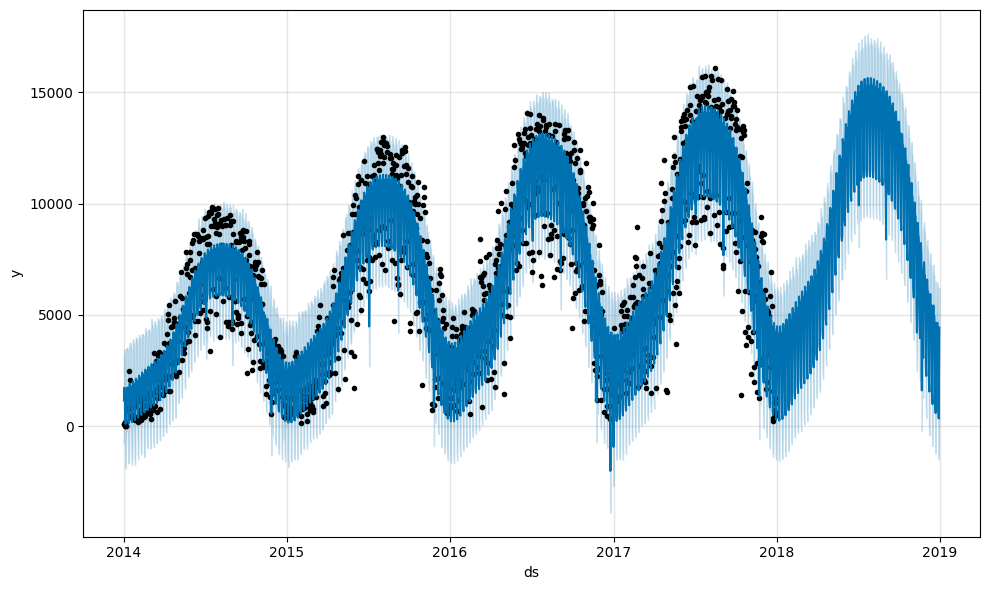

In [11]:
fig = model.plot(forecast)
#creates a plot of the forecasted values, along with their uncertainty intervals, overlaying the original time series data.
plt.show()

We see some downward spikes around the middle of the year and the end of the year. To analyse those spikes, we will look at the components plot as follows:

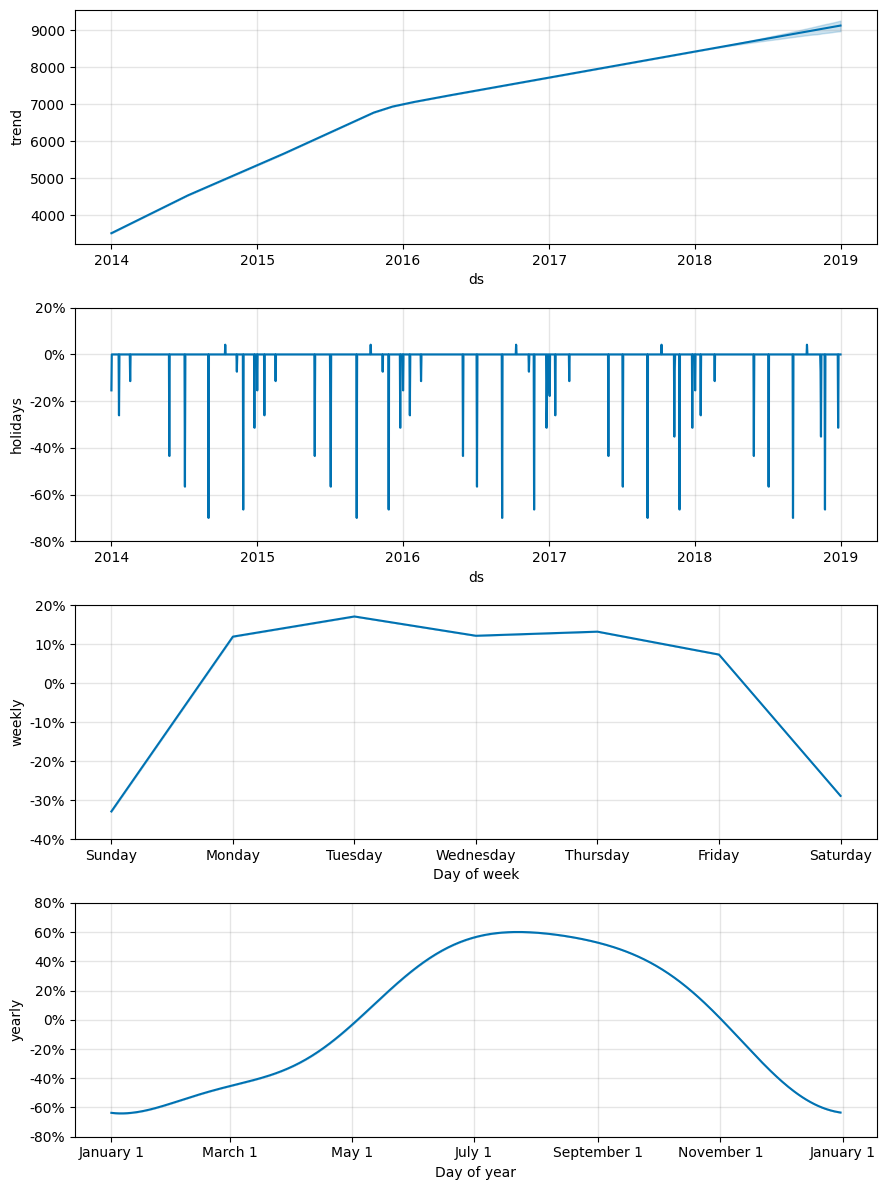

In [12]:
fig2 = model.plot_components(forecast)
plt.show()

## model.plot_components method 

The method is to visualize the individual components of the model's forecast. The method generates a plot that displays the trend, seasonality, and holiday components separately, providing a more in-depth understanding of the underlying patterns and behaviors in your time series data.

The method creates a series of subplots, each representing one of the individual components of the forecast, such as the trend, seasonal components (yearly, weekly, and/or daily), and holidays

## In the resulting plots, you can observe the following:

**Trend:** This subplot shows the overall trend of the time series data, which could be linear or logistic, depending on the model's configuration. It helps you understand the general direction and behavior of the time series data over time, such as increasing, decreasing, or plateauing.

**Seasonality:** The seasonal components of the data are displayed in separate subplots for yearly, weekly, and/or daily seasonality. These subplots show the recurring patterns in the data over different time periods. 

**In the case of multiplicative seasonality, the y-axis of these plots represents the proportional change in the seasonal component, whereas, for additive seasonality, the y-axis represents the absolute change.**

**Holidays:**  this shows impact on the time series data that holidays or special events will have.

------------------
In our case above, the plot sikes where Divvy deviates from the trend, each spike corresponding to a holiday. Each holiday shows decreased usage except for one, which occurs in the final quarter of each year.

In [13]:
model.train_holiday_names
# This outputs a Python object containing an index and the holiday names included in the model
# Each of these holidays has been included in the forecast DataFrame

0                  New Year's Day
1      Martin Luther King Jr. Day
2           Washington's Birthday
3                    Memorial Day
4                Independence Day
5                       Labor Day
6                    Columbus Day
7                    Veterans Day
8                    Thanksgiving
9                   Christmas Day
10       Christmas Day (Observed)
11      New Year's Day (Observed)
12        Veterans Day (Observed)
13    Independence Day (Observed)
dtype: object

In [14]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2014-01-01,3513.232695,-758.052995,3117.291503,3513.232695,3513.232695,0.0,0.0,0.0,0.0,...,0.121722,0.121722,0.121722,-0.636135,-0.636135,-0.636135,0.0,0.0,0.0,1165.590911
1,2014-01-02,3518.593002,29.165429,3462.176678,3518.593002,3518.593002,0.0,0.0,0.0,0.0,...,0.132238,0.132238,0.132238,-0.637638,-0.637638,-0.637638,0.0,0.0,0.0,1740.292615
2,2014-01-03,3523.953310,-165.275414,3298.668643,3523.953310,3523.953310,0.0,0.0,0.0,0.0,...,0.073473,0.073473,0.073473,-0.638805,-0.638805,-0.638805,0.0,0.0,0.0,1531.749736
3,2014-01-04,3529.313617,-1759.009479,1960.057979,3529.313617,3529.313617,0.0,0.0,0.0,0.0,...,-0.289095,-0.289095,-0.289095,-0.639642,-0.639642,-0.639642,0.0,0.0,0.0,251.507058
4,2014-01-05,3534.673925,-1894.253659,1879.493183,3534.673925,3534.673925,0.0,0.0,0.0,0.0,...,-0.329039,-0.329039,-0.329039,-0.640157,-0.640157,-0.640157,0.0,0.0,0.0,108.881912


In Prophet, `model.train_holiday_names` is an attribute of the Prophet model object, which stores the names of holidays used in the model during training. It is useful for tracking which holidays are considered by the model when making predictions or understanding the impact of holidays on the time series.

In [15]:
for holiday in model.train_holiday_names:
    print(holiday)

New Year's Day
Martin Luther King Jr. Day
Washington's Birthday
Memorial Day
Independence Day
Labor Day
Columbus Day
Veterans Day
Thanksgiving
Christmas Day
Christmas Day (Observed)
New Year's Day (Observed)
Veterans Day (Observed)
Independence Day (Observed)


## Check a single example of holiday

In [16]:
forecast["New Year's Day_upper"]


0      -0.153815
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
1818    0.000000
1819    0.000000
1820    0.000000
1821    0.000000
1822    0.000000
Name: New Year's Day_upper, Length: 1823, dtype: float64

Because each row of the forecast DataFrame is a date, most of the values in each holiday column
will be zero, as the holiday does not affect these dates. On the date the holiday occurs, the value will
either be positive, indicating more ridership than otherwise expected, or negative, for less ridership.

Prophet models each holiday as having the same effect every year, so this value will be constant
from year to year. 

### Because we set `seasonality_mode='multiplicative'` in this case, these effects are calculated as a percentage deviation from the Base-Trend

-------------

## Basic Theory on how `seasonality_mode` affect  how holidays are incorporated into the forecast

When you create a Prophet model, you have the option to configure the seasonality mode. There are two options for seasonality_mode: "additive" and "multiplicative". This mode affects how the seasonality components are combined in the model and also how holidays are incorporated into the forecast.

Additive seasonality:
In additive mode, the seasonal and holiday components are added to the base trend to create the final forecast. This mode assumes that the effect of the seasonal components and holidays remains constant over time, regardless of the magnitude of the base trend. Additive seasonality is generally suitable for time series data with a constant or linear trend.

Multiplicative seasonality:
In multiplicative mode, the seasonal and holiday components are multiplied by the base trend to create the final forecast. This mode assumes that the effect of the seasonal components and holidays increases or decreases proportionally with the magnitude of the base trend. Multiplicative seasonality is more suitable for time series data with an exponential or non-linear trend.

### When the seasonality_mode is set to "multiplicative", the impact of holidays on the forecast will also be treated as a multiplicative factor. This means that the holiday effect will be proportionally stronger when the base trend is higher and weaker when the base trend is lower. Conversely, when the seasonality_mode is set to "additive", the holiday effect will be constant and independent of the base trend.

In summary, the seasonality_mode setting in a Prophet time series project affects not only the seasonal components but also how holidays are incorporated into the forecast. The choice between additive and multiplicative seasonality depends on the characteristics of your time series data and how the seasonality and holiday effects interact with the base trend.

In [17]:
forecast[forecast["New Year's Day_upper"]!= 0]["New Year's Day_upper"]

0      -0.153815
362    -0.153815
727    -0.153815
1093   -0.153815
1458   -0.153815
Name: New Year's Day_upper, dtype: float64

Each of these holidays has been included in the forecast DataFrame, which is the output after `forecast = model.predict(future)`

For each holiday, three new columns are added 
- for the predicted effect of that holiday, as well as 
- lower and 
- upper bounds for the uncertainty, 
 
For example, "New Year's Day", "New Year's Day_lower", and "New Year's Day_upper". 

Using these new columns, we can see precisely what effect each holiday has on our forecast by printing the first non-zero value for each holiday in the forecast DataFrame.

To do this, let’s create a quick function called calculate_first_non_zero_holiday_effect. The function takes a forecast
DataFrame and the name of a holiday; it returns the first value

In [18]:
import pandas as pd

def calculate_first_non_zero_holiday_effect(forecast_model, holiday):
    """
    Filters the non-zero holiday effects from the forecast model for a given holiday.
    
    Args:
        forecast_model (pd.DataFrame): The DataFrame containing the forecast results.
        holiday (str): The name of the holiday.
    
    Returns:
        pd.Series: A pandas Series with the non-zero holiday effects.
    """
    non_zero_effects = forecast_model[forecast_model[holiday] != 0][holiday]
    
    # Now take the first non zero holidate effect by grabbing the one at 0th index
    return non_zero_effects.values[0]
    
def create_holiday_effect_dataframe(model):
    """
    Creates a pandas DataFrame containing the first non-zero effect for each holiday.
    
    Args:
        model (Prophet model): The trained FB Prophet model.
    
    Returns:
        pd.DataFrame: The DataFrame containing the holiday names and their effects.
    """
    # Python list comprehension to loop over each holiday name and call the
    #calculate_first_non_zero_holiday_effect
    holiday_effects = [calculate_first_non_zero_holiday_effect(forecast, holiday)
                       for holiday in model.train_holiday_names]
    
    return pd.DataFrame({'holiday': model.train_holiday_names, 'effect': holiday_effects})

# Usage
# Assuming `model` is an already trained FB Prophet model
holiday_effect_df = create_holiday_effect_dataframe(model)

holiday_effect_df.head(len(holiday_effect_df))


,holiday,effect
0,New Year's Day,-0.153815
1,Martin Luther King Jr. Day,-0.260369
2,Washington's Birthday,-0.114164
3,Memorial Day,-0.434442
4,Independence Day,-0.565412
5,Labor Day,-0.699320
6,Columbus Day,0.041567
7,Veterans Day,-0.073762
8,Thanksgiving,-0.663246
9,Christmas Day,-0.313577


## Interpretation of above 

Now, we can clearly see that Columbus Day creates a 5% boost to ridership for Divvy. All other
holidays have negative effects, with Labor Day having the strongest at 69% fewer riders than the trend
would otherwise predict.

---------------------------------

# Further Controls on Holidays

## Adding default state/province holidays

### `make_holidays_df` function of prophet takes a list of years for which to populate the holidays as input, as well as arguments for the country and state or province. 

Note that you must use all years in your training DataFrame,
as well as all the years for which you intend to predict. That is why, in the following code, we build a
year list to contain all unique years in the training DataFrame. Then, because our make_future_
dataframe command will add one year to the forecast, we need to extend that year list to include
one additional year:


In [19]:
year_list = df['ds'].dt.year.unique().tolist()
year_list

[2014, 2015, 2016, 2017]

In [20]:
# Now grab the last Year and add another year to it
year_list.append(year_list[-1] + 1)

In [21]:
from prophet.make_holidays import make_holidays_df

def create_holidays_df(df, country='US', state='IL'):
    """
    Create a dataframe of holidays for a given country and state, based on a given dataframe containing datetime values.

    Parameters:
    - country (str): The name of the country for which the holidays are to be generated. Default is 'US'.
    - state (str): The name of the state for which the holidays are to be generated. Default is 'IL'.

    Returns:
    - holidays_df (pandas DataFrame): A dataframe containing the dates of holidays for the specified country and state. It has two columns:
    - 'ds' (datetime): The date of the holiday.
    - 'holiday' (str): The name of the holiday.

    Usage:
    - df = pd.DataFrame({'ds': pd.date_range(start='2021-01-01', end='2022-12-31', freq='D')})
    - holidays_df = create_holidays_df(df, country='US', state='IL')
    """
    
    
    holidays_df = make_holidays_df(year_list=year_list,
                                   country=country,
                                   state=state)
    return holidays_df

holidays = create_holidays_df(df, country='US', state='IL')


In [22]:
holidays.head()

,ds,holiday
0,2016-01-01,New Year's Day
1,2016-01-18,Martin Luther King Jr. Day
2,2016-02-12,Lincoln's Birthday
3,2016-02-15,Washington's Birthday
4,2016-03-07,Casimir Pulaski Day


In [23]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=4,
                holidays=holidays)
model.fit(df)
future = model.make_future_dataframe(periods=365)

# Above line creates a new DataFrame that extends into the future for a specified number of periods, in this case, 365 periods. The new DataFrame will have the same structure as the original input DataFrame, with a single datetime column named 'ds'. It will include all the dates from the original DataFrame and extend it by adding 365 new rows with future dates.

forecast = model.predict(future)

03:29:14 - cmdstanpy - INFO - Chain [1] start processing
03:29:15 - cmdstanpy - INFO - Chain [1] done processing


If I execute `model.train_holiday_names` now, I will see 4 additional
holidays specific to Illinois that are not official United States holidays: Lincoln’s Birthday, Casimir
Pulaski Day, Election Day, and Lincoln’s Birthday

In [24]:
model.train_holiday_names

0                    New Year's Day
1        Martin Luther King Jr. Day
2                Lincoln's Birthday
3             Washington's Birthday
4               Casimir Pulaski Day
5                      Memorial Day
6                  Independence Day
7                         Labor Day
8                      Columbus Day
9                      Election Day
10                     Veterans Day
11                     Thanksgiving
12                    Christmas Day
13         Christmas Day (Observed)
14        New Year's Day (Observed)
15    Lincoln's Birthday (Observed)
16          Veterans Day (Observed)
17      Independence Day (Observed)
dtype: object

## `yearly_seasonality` Explanations

When you set **` yearly_seasonality=4`**, you're specifying that the yearly seasonal component should be modeled using 4 Fourier terms. This can be thought of as using 4 pairs of sine and cosine functions to approximate the yearly seasonal pattern.

The choice of the number of Fourier terms can significantly affect the flexibility of the seasonal component:

If you choose a low number of Fourier terms, such as 4 in your example, the seasonal component will be smoother and less flexible. This is suitable when you believe that the dominant factors driving the yearly seasonal pattern are relatively few and that a smoother representation will capture the main patterns more effectively. A low number of terms can also help prevent overfitting, as it restricts the complexity of the seasonal component.

Example: Suppose you are analyzing the sales of a company that sells winter clothing. The sales have a strong yearly seasonality, with sales peaking in winter and dropping in the summer. Using a low number of Fourier terms (e.g., 4) might be appropriate in this case, as you would expect the main driver of seasonality to be the temperature changes between the seasons, and a smoother seasonal component would capture this pattern.


# Add custom holidays and Creating multi-day holidays

For Bike rider behaviour, its likely that Black Friday and Christmas Eve would also have an effect on that deviates from the expected trend. So, here we decide to include these in our forecast.

In [25]:
# first create default US holidays
holidays = make_holidays_df(year_list=year_list, country='US')

And for the custom holidays, it must include all occurrences of the holiday in the past (at least, as far back
as your training data goes) and into the future that we intend to forecast

In [26]:
black_friday = pd.DataFrame({'holiday': 'Black Friday',
                             'ds': pd.to_datetime(['2014-11-28',
                                                   '2015-11-27',
                                                   '2016-11-25',
                                                   '2017-11-24',
                                                   '2018-11-23'])})
christmas_eve = pd.DataFrame({'holiday': 'Christmas Eve',
                              'ds': pd.to_datetime(['2014-12-24',
                                                    '2015-12-24',
                                                    '2016-12-24',
                                                    '2017-12-24',
                                                    '2018-12-24'])})

In [27]:
# Now just concatenate these three holiday DataFrames into one
holidays = pd.concat([holidays, black_friday, christmas_eve]
                    ).sort_values('ds').reset_index(drop=True)

In [28]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=4,
                holidays=holidays)
model.fit(df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

03:29:15 - cmdstanpy - INFO - Chain [1] start processing
03:29:15 - cmdstanpy - INFO - Chain [1] done processing


In [44]:
model.train_holiday_names
# This outputs a Python object containing an index and the holiday names included in the model
# Each of these holidays has been included in the forecast DataFrame


0                  New Year's Day
1      Martin Luther King Jr. Day
2           Washington's Birthday
3                    Memorial Day
4                Independence Day
5                Taste of Chicago
6                       Labor Day
7                    Columbus Day
8                    Veterans Day
9                    Thanksgiving
10                   Black Friday
11                  Christmas Eve
12                  Christmas Day
13    Independence Day (Observed)
14       Christmas Day (Observed)
15      New Year's Day (Observed)
16        Veterans Day (Observed)
dtype: object

As expected, now you will indeed see two additional holidays each year, one for Black Friday and one for Thanksgiving.

## Multiday_Holiday

In [29]:
holidays = make_holidays_df(year_list=year_list, country='US')

multiday_Holiday = pd.DataFrame({'holiday': 'Taste of Chicago',
                                 'ds': pd.to_datetime(['2014-07-09',
                                                       '2015-07-08',
                                                       '2016-07-06',
                                                       '2017-07-05',
                                                       '2018-07-11']),
                                 'lower_window': 0,
                                 'upper_window': 4})
holidays = pd.concat([holidays, multiday_Holiday]
                    ).sort_values('ds').reset_index(drop=True)

In [ ]:
holidays.head(10)